# Data Wrangling

# Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import time
import datetime


import numpy as np
import pandas as pd
import polars as pl
import pyarrow as pa

import holidays

# Data loading

For my personal goal one. I compare pandas and polars in terms of data file (.csv) reading, data rewriting (adding new columns), data aggregations(groupby().mean()), and table joins, the four most common operations in wrangling data. I also compare how easy it is to statistically analyse the data.

In [2]:
root = "../Data/" # Set root folder

## Compare the efficiency of reading csv files using Pandas and Polars

In [3]:
%%time
# Read data with pandas
df_train_pd = pd.read_csv(os.path.join(root, "train.csv"))
df_client_pd = pd.read_csv(os.path.join(root, "client.csv"))
df_gas_prices_pd = pd.read_csv(os.path.join(root, "gas_prices.csv"))
df_electricity_prices_pd = pd.read_csv(os.path.join(root, "electricity_prices.csv"))
df_forecast_weather_pd = pd.read_csv(os.path.join(root, "forecast_weather.csv"))
df_historical_weather_pd = pd.read_csv(os.path.join(root, "historical_weather.csv"))
df_weather_station_to_county_mapping_pd = pd.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"))

CPU times: total: 3.98 s
Wall time: 8.55 s


In [4]:
%%time
# Read data with polars
df_train = pl.read_csv(os.path.join(root, "train.csv"),try_parse_dates=True,)
df_client = pl.read_csv(os.path.join(root, "client.csv"),try_parse_dates=True,)
df_gas_prices = pl.read_csv(os.path.join(root, "gas_prices.csv"),try_parse_dates=True,)
df_electricity_prices = pl.read_csv(os.path.join(root, "electricity_prices.csv"),try_parse_dates=True,)
df_forecast_weather = pl.read_csv(os.path.join(root, "forecast_weather.csv"),try_parse_dates=True,)
df_historical_weather = pl.read_csv(os.path.join(root, "historical_weather.csv"),try_parse_dates=True,)
df_weather_station_to_county_mapping = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"),try_parse_dates=True,)

CPU times: total: 5.95 s
Wall time: 809 ms


In [5]:
df_train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


In [6]:
# Convert to datetime in pandas
df_train_pd["datetime"] = pd.to_datetime(df_train_pd["datetime"])
df_train_pd["datetime"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2018352 entries, 0 to 2018351
Series name: datetime
Non-Null Count    Dtype         
--------------    -----         
2018352 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 15.4 MB


In [7]:
df_train.schema

OrderedDict([('county', Int64),
             ('is_business', Int64),
             ('product_type', Int64),
             ('target', Float64),
             ('is_consumption', Int64),
             ('datetime', Datetime(time_unit='us', time_zone=None)),
             ('data_block_id', Int64),
             ('row_id', Int64),
             ('prediction_unit_id', Int64)])

### Conclusion

From the above run results can be seen, polars of the actual reading speed (Wall time) is significantly faster, and in reading csv files can automatically identify the datetime type of data for conversion, while pandas can only be used pd. todatetime () manually converted datetime type.

## Compare the efficiency of data rewriting (adding new columns)

In [8]:
%%time
# add date column with pandas
df_train_pd['date'] = df_train_pd['datetime'].dt.date

CPU times: total: 141 ms
Wall time: 321 ms


In [11]:
%%time
# add date column with polars
df_train = df_train.with_columns(
    pl.col('datetime').dt.date().alias("date")
    )

CPU times: total: 0 ns
Wall time: 22 ms


### Conclusion

As you can see from the results of the above run, polar table calculations and add new columns is also faster than pandas, but the syntax structure is slightly more complex than pandas.

## Compare the efficiency of data aggregations(groupby().mean())

In [28]:
%%time
# Calculation of average daily production and consumption in Estonia during the year using pandas
df_train_pd_grouped_con=df_train_pd[df_train_pd['is_consumption']==1].groupby("date").mean().reset_index()
df_train_pd_grouped_pro=df_train_pd[df_train_pd['is_consumption']==0].groupby("date").mean().reset_index()

CPU times: total: 234 ms
Wall time: 387 ms


CPU times: total: 0 ns
Wall time: 28 ms


<Axes: xlabel='date'>

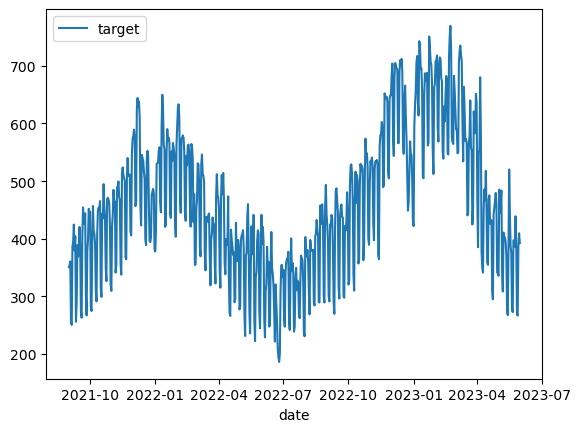

In [31]:
#Quickly draw a line graph of consunption with pandas
df_train_pd_grouped_con.plot(x='date',y='target', use_index=True)

<Axes: xlabel='date'>

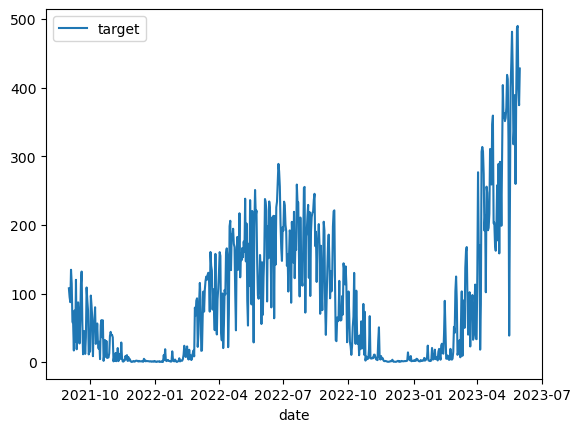

In [32]:
#Quickly draw a line graph of production with pandas
df_train_pd_grouped_pro.plot(x='date',y='target', use_index=True)

In [34]:
%%time
# Calculation of average daily production and consumption in Estonia during the year using polars
df_train_grouped_con = df_train.filter(pl.col("is_consumption") == 1).groupby("date").agg(pl.col("target").mean().alias("target"))
df_train_grouped_pro = df_train.filter(pl.col("is_consumption") == 0).groupby("date").agg(pl.col("target").mean().alias("target"))

CPU times: total: 31.2 ms
Wall time: 44.5 ms


### Conclusion

Polars wins again in the speed of aggregation analysis. But pandas is able to make graphs easily without the help of other packages.

## Compare the efficiency of table joins

In [38]:
%%time
#merege the client and train data with pandas
df_train_client_pd = pd.merge(df_train_pd, df_client_pd, on=["county", "is_business", "product_type", "date"], how="left")

CPU times: total: 250 ms
Wall time: 365 ms


In [39]:
%%time
#merege the client and train data with polars
df_train_client = df_train.join(df_client, on=["county", "is_business", "product_type", "date"], how="left")

CPU times: total: 250 ms
Wall time: 96.5 ms


### Conclusion

The speed improvement of polars on table join is not as huge as the previous items. It takes about a third of the time of pandas, but the previous items take less than a tenth of the time of pandas.

The data type of the 'datetime' column in both tables is str, which we need to convert to the datetime format.

# Summaries

In summary, polars has a significant speed advantage over pandas, therefore,it can greatly improve the efficiency of the programme when dealing with large datasets. But pandas is better in the community. With a search engine, you can solve most problems related to pandas and get a lot of tutorials. And pandas can quickly visualise data without the use of other tools, which can help data workers to understand the characteristics of the data more easily.